In [1]:
import keras
import matplotlib.patches as patches
import numpy as np
import os
import pandas as pd
import random
import tensorflow as tf

from matplotlib import pyplot as plt
from keras import applications
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten
from skimage import measure
from skimage.transform import resize

from utils import (
    draw_image, iou, map_iou, parse_dataset, get_dicom_fps, predict_submit
)
from utils.generator import DataGenerator

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
ROOT_DIR = os.path.abspath('..')
MODEL_DIR = os.path.join(ROOT_DIR, 'model')
RAWDATA_DIR = os.path.join(ROOT_DIR, 'data', 'raw')
PREPROCESS_DIR = os.path.join(ROOT_DIR, 'data', 'preprocess')
TRAIN_DICOM_DIR = os.path.join(RAWDATA_DIR, 'stage_1_train_images')
TEST_DICOM_DIR = os.path.join(RAWDATA_DIR, 'stage_1_test_images')

In [3]:
df_train = pd.read_csv(os.path.join(PREPROCESS_DIR, 'train.csv'))
train_patient_ids = sorted(list(df_train.patientId.unique()))

df_test = pd.read_csv(os.path.join(PREPROCESS_DIR, 'test.csv'))
test_patient_ids = list(df_test.patientId.unique())

In [4]:
random.seed(42)
random.shuffle(train_patient_ids)

validation_split = 0.1
split_index = int((1 - validation_split) * len(train_patient_ids))

patient_ids_train = train_patient_ids[:split_index]
patient_ids_validation = train_patient_ids[split_index:]

print(f'train len: {len(patient_ids_train)}\nvalidation len: {len(patient_ids_validation)}')

train len: 23115
validation len: 2569


In [6]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    return keras.layers.add([x, inputs])

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input
    inputs = keras.Input(shape=(input_size, input_size, 1))
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(inputs)
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        x = create_downsample(channels, x)
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    # output
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(1, 1, activation='sigmoid')(x)
    outputs = keras.layers.UpSampling2D(2**depth)(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [7]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

def iou_bce_loss(y_true, y_pred):
    """ combine bce loss and iou loss
    """
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * iou_loss(y_true, y_pred)


def mean_iou(y_true, y_pred):
    """ mean iou as a metric
    """
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def cosine_annealing(x):
    lr = 0.001
    epochs = 25
    return lr*(np.cos(np.pi*x/epochs)+1.)/2

learning_rate = tf.keras.callbacks.LearningRateScheduler(cosine_annealing)

In [8]:
# keras.backend.get_session().run(tf.global_variables_initializer())

model = create_network(input_size=256, channels=32, n_blocks=2, depth=4)
model.compile(optimizer='adam',
              loss=iou_bce_loss,
              metrics=['accuracy', mean_iou])

In [10]:
# https://github.com/keras-team/keras/issues/4623#issuecomment-269125127
keras.backend.get_session().run(tf.global_variables_initializer())
input_shape = (256, 256, 1)

generator_train = DataGenerator(
    TRAIN_DICOM_DIR,
    patient_ids_train,
    df_train,
    input_shape=input_shape,
    shuffle=True, augment=True, predict=False)
generator_validation = DataGenerator(
    TRAIN_DICOM_DIR,
    patient_ids_validation,
    df_train,
    input_shape=input_shape,
    shuffle=False, augment=False, predict=False)
generator_test = DataGenerator(
    TEST_DICOM_DIR,
    test_patient_ids,
    df_test,
    input_shape=input_shape,
    shuffle=False, augment=False, predict=True)

history = model.fit_generator(
    generator_train,
    validation_data=generator_validation,
    callbacks=[learning_rate],
    epochs=25,
    workers=4,
    use_multiprocessing=True
)

Epoch 1/25
721/722 [============================>.] - ETA: 0s - loss: 0.4774 - acc: 0.9630 - mean_iou: 0.6170Epoch 1/25
Epoch 1/25
722/722 [==============================] - 357s 494ms/step - loss: 0.4773 - acc: 0.9630 - mean_iou: 0.6171 - val_loss: 0.4670 - val_acc: 0.9585 - val_mean_iou: 0.6140
Epoch 2/25
722/722 [==============================] - 353s 489ms/step - loss: 0.4484 - acc: 0.9667 - mean_iou: 0.6665 - val_loss: 0.4537 - val_acc: 0.9609 - val_mean_iou: 0.6130
Epoch 3/25
722/722 [==============================] - 354s 490ms/step - loss: 0.4392 - acc: 0.9676 - mean_iou: 0.6789 - val_loss: 0.4746 - val_acc: 0.9560 - val_mean_iou: 0.6037
Epoch 4/25
722/722 [==============================] - 355s 491ms/step - loss: 0.4329 - acc: 0.9688 - mean_iou: 0.6897 - val_loss: 0.4244 - val_acc: 0.9684 - val_mean_iou: 0.6893
Epoch 5/25
722/722 [==============================] - 354s 490ms/step - loss: 0.4256 - acc: 0.9696 - mean_iou: 0.6984 - val_loss: 0.4492 - val_acc: 0.9610 - val_mean_io

In [1]:
# model.summary()

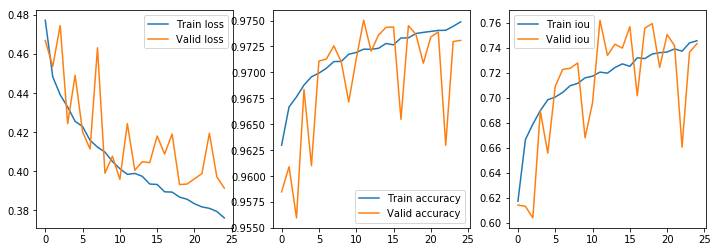

In [11]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["acc"], label="Train accuracy")
plt.plot(history.epoch, history.history["val_acc"], label="Valid accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["mean_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_mean_iou"], label="Valid iou")
plt.legend()
plt.show()

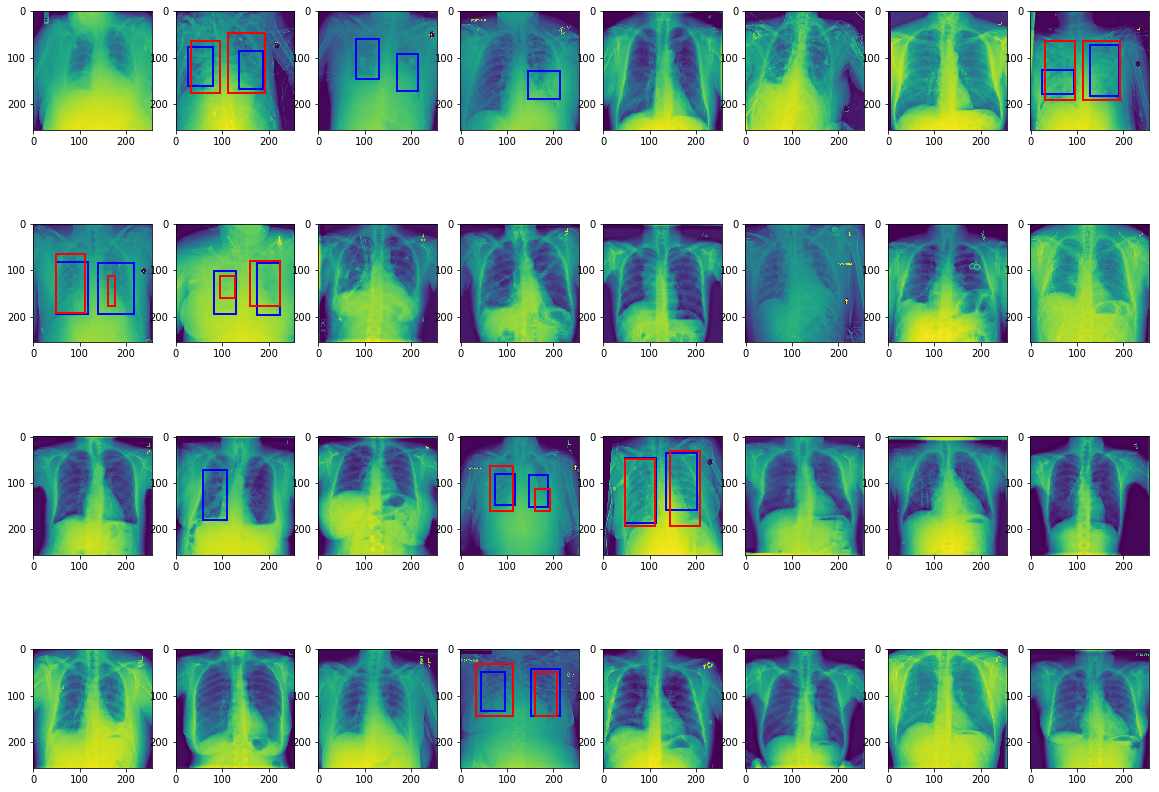

In [12]:
# will fetch one batch at a time
for imgs, msks in generator_validation:
    """
    imgs.shape: (32, 256, 256, 1)
    since batch_size is 32
    """
    
    # predict batch of images
    preds = model.predict(imgs)

    # create figure (4*8=32)
    f, axarr = plt.subplots(4, 8, figsize=(20,15))
    axarr = axarr.ravel()
    axidx = 0
    # loop through batch
    for img, msk, pred in zip(imgs, msks, preds):
        # plot image
        axarr[axidx].imshow(img[:, :, 0])

        # true mask
        comp = msk[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        for region in measure.regionprops(comp):
            # retrieve x, y, height and width
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle(
                (x, y), width, height, linewidth=2, edgecolor='b', facecolor='none'
            ))

        # predicted mask
        comp = pred[:, :, 0] > 0.5
        # apply connected components
        comp = measure.label(comp)
        # apply bounding boxes
        for region in measure.regionprops(comp):
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            axarr[axidx].add_patch(patches.Rectangle(
                (x, y), width, height, linewidth=2, edgecolor='r', facecolor='none'
            ))
        axidx += 1
    plt.show()
    # only plot one batch
    break

In [13]:
submission_dict = {}
for imgs, patient_ids in generator_test:
    preds = model.predict(imgs)
    for pred, patient_id in zip(preds, patient_ids):
        pred = resize(pred, (1024, 1024), mode='reflect')
        comp = pred[:, :, 0] > 0.5
        comp = measure.label(comp)
        predictionString = ''
        for region in measure.regionprops(comp):
            y, x, y2, x2 = region.bbox
            height = y2 - y
            width = x2 - x
            # proxy for confidence score
            conf = np.mean(pred[y:y+height, x:x+width])
            predictionString += ' '.join([str(v) for v in [predictionString, conf, x, y, width, height]])
        submission_dict[patient_id] = predictionString
    # stop if we've got them all
    if len(submission_dict) >= df_test.shape[0]:
        break

In [18]:
"""
- loss: 0.3762 
- acc: 0.9749
- mean_iou: 0.7457
- val_loss: 0.3914
- val_acc: 0.9731
- val_mean_iou: 0.7434
"""

{'10be8144-046d-478b-8a8d-3b41af8b229b': '',
 '2cd2f674-1018-4f20-a1ee-cf09928696d8': '',
 '1352a7f3-1f0d-4f1f-af05-daa5d7f8624a': '',
 '1a0aa05e-697c-40ba-a0c0-1dc64a913e3f': ' 0.6946808249741879 193 384 127 191',
 '13f8bb2b-9c21-4131-aee1-eef3bc0cf88b': '',
 '1c524fb1-768e-481f-a1d8-d9191dd09bfe': '',
 '2ae3e7ba-a0fe-4f0a-96db-d337714aa657': '',
 '28ba0617-0cac-4198-8b8a-c35fde545ace': '',
 '3041269d-fed6-450a-b6dc-39bce3d2dd60': ' 0.7793261320091873 832 448 64 66',
 '0ed09fd0-a4f5-4440-9fe7-6272d7987f33': '',
 '265cf450-572c-48aa-90cd-fb7e3eff3ccf': '',
 '036a1ed9-6ce8-4a5c-80aa-4790abe94dfc': '',
 '259cc555-42e4-45d5-b803-d00a51e34f5b': '',
 '0103fadb-1663-40a6-8a9e-09d626cd2091': '',
 '11a4ad3f-7899-4c3c-a88d-f1c799ec04df': '',
 '00dd08bb-b7ea-4617-801e-02b3051c3475': ' 0.5051570574409432 258 258 125 252',
 '26e0313c-ca69-42dd-946e-5e0fa33c7e1a': '',
 '29e35700-6034-41e6-a2d6-efc2b4f58c04': '',
 '27fa7496-e222-4016-8d1a-5a8dd4db52ed': ' 0.7168221611235527 513 385 255 193',
 '1b605

In [14]:
sub = pd.DataFrame.from_dict(submission_dict, orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']
sub.to_csv('akita_cute_submission.csv')

In [15]:
model.save('akita_cute.h5')
# https://github.com/keras-team/keras/issues/5916#issuecomment-300038263
# custom_objects = {
#     'iou_bce_loss': iou_bce_loss,
#     'mean_iou': mean_iou
# }
# model = load_model('akita_cute.h5', custom_objects=custom_objects)